In [2]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

In [3]:
import torch
cuda = torch.cuda.is_available()

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Flatten the 2d-array image into a vector
flatten = lambda x: ToTensor()(x).view(28**2)

# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=flatten, download=True)
dset_test  = MNIST("./", train=False, transform=flatten)

# The digit classes to use
classes = [0,1,2,3,4,5,6,7,8,9]

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    from functools import reduce
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)


# The loaders perform the actual work
batch_size = 64
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.train_labels), pin_memory=cuda)
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.test_labels), pin_memory=cuda)

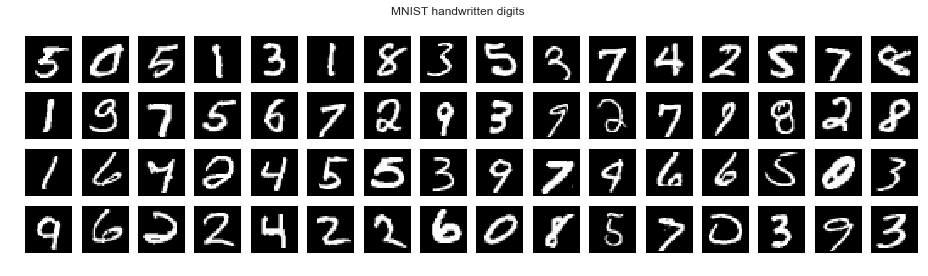

In [4]:
# Plot a batch of MNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

In [5]:
def uniform_stratified_sampler(labels, n=None):
    """
    Stratified sampler that distributes labels uniformly by
    sampling at most n data points per class
    """
    from functools import reduce
    # Only choose digits in n_labels
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))

    # Ensure uniform distribution of labels
    np.random.shuffle(indices)
    indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in classes])

    indices = torch.from_numpy(indices)
    sampler = SubsetRandomSampler(indices)
    return sampler


batch_size = 64

# Specify how many labelled examples we want per digit class
labels_per_class = 10

# Large pool of unlabelled data
unlabelled = DataLoader(dset_train, batch_size=batch_size, 
                        sampler=stratified_sampler(dset_train.train_labels), pin_memory=cuda)

# Smaller pool of labelled data
labelled = DataLoader(dset_train, batch_size=batch_size,
                      sampler=uniform_stratified_sampler(dset_train.train_labels, labels_per_class),
                      pin_memory=cuda)

In [7]:
import torch.nn as nn
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias=True) 
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes, bias=True) 
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        
        return nn.functional.softmax(out, dim=1)

ffnn = NeuralNet(784,128,10).cuda()

In [8]:
import torch.optim as optim

# if you want L2 regularization, then add weight_decay to SGD
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# We will use pixel wise mean-squared error as our loss function
loss_function = nn.CrossEntropyLoss()

NameError: name 'net' is not defined